In [18]:
import scda
import pprint
import logging
import os
import numpy as np
scda.configure_log()

% matplotlib inline
import matplotlib.pyplot as plt

import scipy.special

## Prepare a design survey test to run as serial bash script

In [19]:
survey_params = {'Pupil': { 'centobs': [9], 'N': 500 },
                 'FPM': { 'R': [4.0,5.0], 'fpmres':100 },
                 'LS': { 'id':[13], 'od':[92] },
                 'Image': { 'c':10., 'owa':12., 'dR':-0.1, 'bw':0.103, 'fpres':3, 'Nlam':4}}

In [20]:
survey_dir = os.path.expanduser("/astro/opticslab1/AMPL/SCDA/nonlinear_testing/")
if not os.path.exists(survey_dir):
    os.mkdir(survey_dir)
    print("Created survey directory {:s}".format(survey_dir))
else:
    print("The survey directory {:s} already exists".format(survey_dir))

os.chdir(survey_dir)
survey_fname = os.path.basename(survey_dir)
ampl_src_dir = os.path.normpath("./amplsrc")
sol_dir = os.path.normpath("./solutions")
log_dir = os.path.normpath("./logs")

fileorg = {'work dir':'.', 'ampl src dir':ampl_src_dir,
           'log dir':log_dir, 'sol dir':sol_dir}

The survey directory /astro/opticslab1/AMPL/SCDA/nonlinear_testing/ already exists


## Initiate a survey object with the above parameter combinations 

In [21]:
axisym_demo_survey = scda.DesignParamSurvey(scda.AxisymAPLC, survey_params,
                                            fileorg=fileorg,
                                            solver={'method': 'dualsimp', 'presolve':True})

In [22]:
os.getcwd()

'/astro/opticslab1/AMPL/SCDA/nonlinear_testing'

In [23]:
axisym_demo_survey.describe()

This survey has 1 design parameter combinations.
0 parameters are varied: ()

File organization:
{'FPM dir': '.',
 'LS dir': '.',
 'TelAp dir': '.',
 'ampl src dir': 'amplsrc',
 'eval dir': '.',
 'eval subdir': '.',
 'log dir': 'logs',
 'plot dir': '.',
 'slurm dir': '.',
 'sol dir': 'solutions',
 'work dir': '.'}

All input files exist? True

Last coronagraph in survey list:
Job label APLC_axisym_cobs09N0500_FPMrad400res100_LS13D92_ImgC100BW10Nlam04dR1OWA1200res3_lindualsimppre1
Varied parameter combo tuple:
()


## Write the batch of AMPL files

In [7]:
axisym_demo_survey.write_ampl_batch(overwrite=True)

Wrote all 1 of 1 design survey AMPL programs into amplsrc


In [8]:
axisym_demo_survey.write_serial_bash(overwrite=True)

Wrote serial bash survey script to ./run_nonlinear_testing_serial.sh


'./run_nonlinear_testing_serial.sh'

# STOP, run the AMPL scripts

## Write tables summarizing the design survey configuration and status to a spreadsheet

In [25]:
for coron in axisym_demo_survey.coron_list:
    coron.get_metrics()

////////////////////////////////////////////////////////
APLC_axisym_cobs09N0500_FPMrad400res100_LS13D92_ImgC100BW10Nlam04dR1OWA1200res3_lindualsimppre1
Incident energy on aperture (dimensionless): 0.779
Non-binary residuals, as a percentage of clear telescope aperture area: 1.12%
Band-averaged total throughput: 48.20%
Band-averaged half-max throughput: 23.17%
Band-averaged half-max throughput, circ. ref.: 22.98%
Band-averaged r=.7 lam/D throughput: 29.38%
Band-averaged r=.7 lam/D throughput, circ. ref.: 29.14%
Band-averaged relative half-max throughput: 47.34%
Band-averaged relative r=0.7 lam/D throughput: 42.95%
Band-averaged FWHM PSF area / (lambda0/D)^2: 1.10


In [17]:
axisym_demo_survey.write_spreadsheet()

Wrote design survey spreadsheet to ./nonlinear_testing_kstlaurent_2018-04-04.csv


## Evaluate an individual design

In [5]:
test_coron = axisym_demo_survey.coron_list[0] 

In [6]:
N = test_coron.design['Pupil']['N']
M = test_coron.design['FPM']['M']
FPMrad = test_coron.design['FPM']['R']
fpmres = test_coron.design['FPM']['fpmres']

Nimg = test_coron.design['Image']['Nimg']
#fp2res = test_coron.design['Image']['fpres']
fp2res = 16
owa = test_coron.design['Image']['owa']
owa_eval = owa + 2
Nrho = np.int(np.ceil(owa_eval * fp2res))

dr = 0.5 / N
dmr = 1. / fpmres

bw = test_coron.design['Image']['bw']
Nlam = 5
wrs = np.linspace(1.-bw/2, 1.+bw/2, Nlam)

In [7]:
rs = np.matrix(np.loadtxt(test_coron.fileorg['sol fname'])[:,0]).T
mrs = np.matrix((np.arange(M) + 0.5) / M * FPMrad).T
rhos = np.matrix(np.arange(Nrho) * 1./fp2res).T

TelAp = rs*0.
TelAp[(rs[:,0] > test_coron.design['Pupil']['centobs']*0.5/100)] = 1

Apod = np.matrix(np.loadtxt(test_coron.fileorg['sol fname'])[:,1]).T

LS = rs*0.
LS[((rs > test_coron.design['LS']['id']*0.5/100) & \
    (rs < test_coron.design['LS']['od']*0.5/100))] = 1

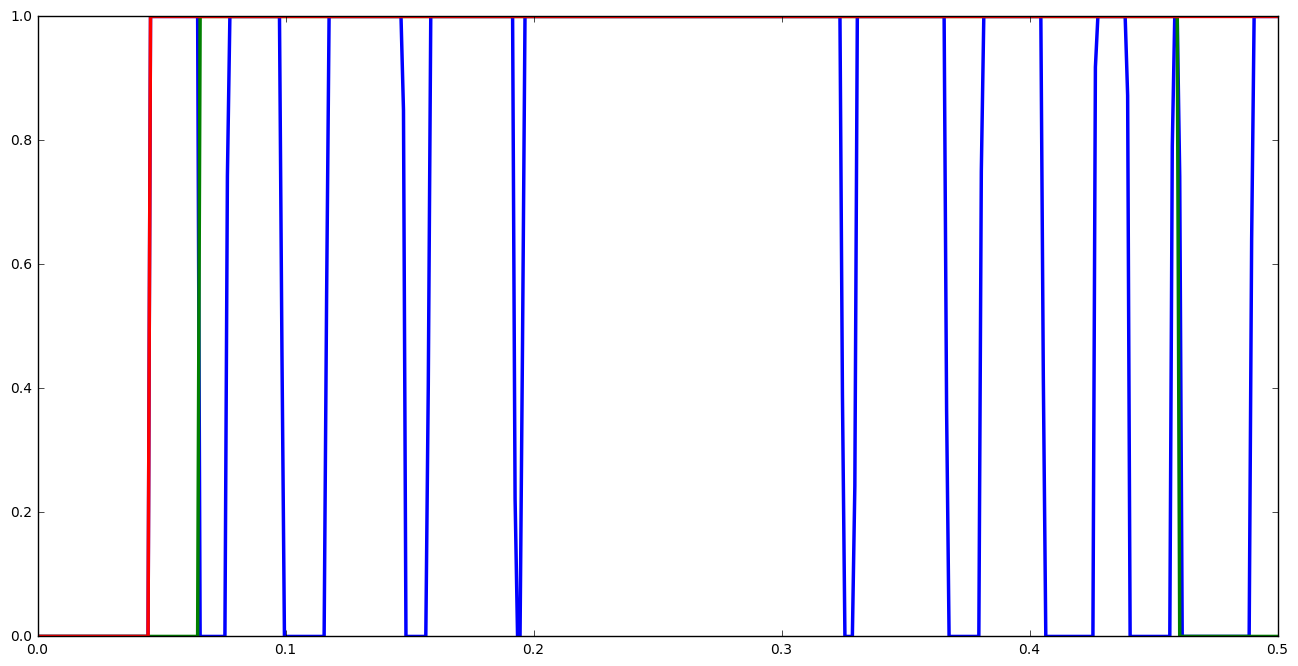

In [8]:
plt.figure(figsize=(16,8))
plt.plot(rs, Apod)
plt.plot(rs, LS)
plt.plot(rs, TelAp)

In [9]:
E_fpm = 2*np.pi*dr * scipy.special.jn(0, 2*np.pi*mrs*rs.T) * np.multiply(rs, Apod)
E_LS = Apod - 2*np.pi*dmr * scipy.special.jn(0, 2*np.pi*rs*mrs.T) * np.multiply(mrs, E_fpm)
E_LS_stop = np.multiply(E_LS, LS)
E_fp2 = 2*np.pi*dr * scipy.special.jn(0, 2*np.pi*rhos*rs.T) * np.multiply(rs, E_LS_stop)

In [10]:
E_unocc = 2*np.pi*dr * scipy.special.jn(0, 2*np.pi*rhos*rs.T) * np.multiply(rs, np.multiply(Apod, LS))

In [11]:
E_unocc_peak = 2*np.pi*dr*rs.T*np.multiply(Apod, LS)
print(E_unocc_peak**2)

[[ 0.22517087]]


In [12]:
(np.pi/4)**2

0.6168502750680849

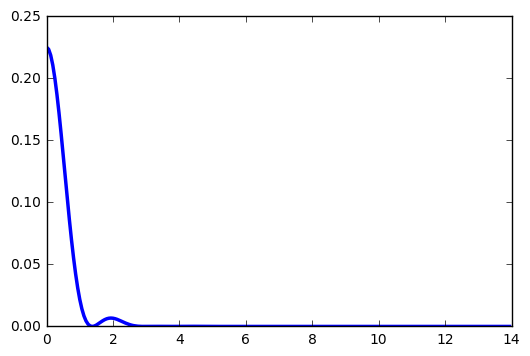

In [13]:
plt.plot(rhos, np.power(np.abs(E_unocc),2))

In [14]:
rhos, scda_intens = test_coron.get_onax_psf(Nlam=5)

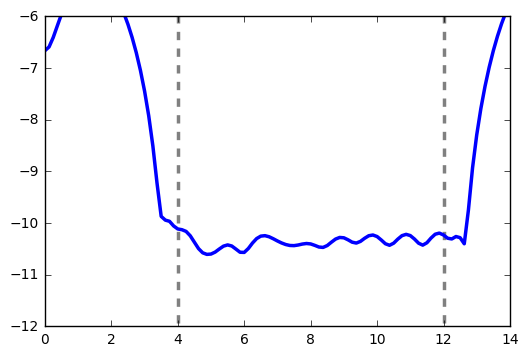

In [15]:
plt.plot(rhos, np.log10(np.mean(scda_intens, axis=0)))
plt.vlines(FPMrad, -100, 100, linestyle='--', color='gray')
plt.vlines(owa, -100, 100, linestyle='--', color='gray')
plt.ylim([-12, -6])

plt.savefig('Baseline.png', dpi=100)